In [1]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
dfTest = pd.read_csv('../data/test.csv',usecols=['srch_id','prop_id','prop_starrating', 'prop_review_score', 'prop_brand_bool',
           'prop_location_score1', 'prop_location_score2',
           'prop_log_historical_price','srch_destination_id','orig_destination_distance','price_usd'])
dfTrain = pd.read_csv('../data/train.csv',usecols=['srch_id','prop_id','prop_starrating', 'prop_review_score', 'prop_brand_bool',
           'prop_location_score1', 'prop_location_score2',
           'prop_log_historical_price','srch_destination_id','booking_bool','orig_destination_distance','price_usd'])

In [3]:
together = pd.concat([dfTest,dfTrain],axis=0)

C:\Users\Rens\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [4]:
meanTestDist = dfTest[['srch_id','orig_destination_distance']].groupby(['srch_id']).mean()
meanTestDist = meanTestDist.rename(columns={'orig_destination_distance':'mean_distance'})
dfTest = dfTest.merge(right=meanTestDist,how="left",on="srch_id",validate="many_to_one")
diff_distance_orig_Test = (dfTest['orig_destination_distance'] - dfTest['mean_distance'])/dfTest['mean_distance']


In [5]:
meanTrainDist = dfTrain[['srch_id','orig_destination_distance']].groupby(['srch_id']).mean()
meanTrainDist = meanTrainDist.rename(columns={'orig_destination_distance':'mean_distance'})
dfTrain = dfTrain.merge(right=meanTrainDist,how="left",on="srch_id",validate="many_to_one")
diff_distance_orig_Train = (dfTrain['orig_destination_distance'] - dfTrain['mean_distance'])/dfTrain['mean_distance']


In [6]:
meanTestPricePerSRCHID = dfTest[['srch_id','price_usd']].groupby(['srch_id']).mean()
meanTestPricePerSRCHID = meanTestPricePerSRCHID.rename(columns={'price_usd':'mean_price_usd'})
dfTest = dfTest.merge(right=meanTestPricePerSRCHID,how="left",on="srch_id",validate="many_to_one")
diff_mean_price_test = (dfTest['price_usd'] - dfTest['mean_price_usd'])/dfTest['mean_price_usd']


In [7]:
meanTrainPricePerSRCHID = dfTrain[['srch_id','price_usd']].groupby(['srch_id']).mean()
meanTrainPricePerSRCHID = meanTrainPricePerSRCHID.rename(columns={'price_usd':'mean_price_usd'})
dfTrain = dfTrain.merge(right=meanTestPricePerSRCHID,how="left",on="srch_id",validate="many_to_one")
diff_mean_price_train = (dfTrain['price_usd'] - dfTrain['mean_price_usd'])/dfTrain['mean_price_usd']


In [8]:
columnsToAvgPerPropID = ['prop_starrating', 'prop_review_score', 'prop_brand_bool',
           'prop_location_score1', 'prop_location_score2',
           'prop_log_historical_price']
groupedMean = together.groupby('prop_id')[columnsToAvgPerPropID].mean()
groupedMean = groupedMean.add_prefix("mean_").reset_index()
groupedMean.to_csv("meansTotal.csv",index=False)

In [9]:
groupedPropDest = dfTrain.groupby(['srch_destination_id','prop_id']).mean().reset_index()
groupedPropDest = groupedPropDest.rename(columns = {"booking_bool": "booking_prop_dest_mean"})

In [10]:
groupedPropTotal = dfTrain.groupby(['prop_id']).mean().reset_index()
groupedPropTotal = groupedPropTotal.rename(columns = {"booking_bool": "booking_prop_total_mean"})

In [11]:
def joinPropDest(df):
    df = df.merge(right=groupedPropDest[['srch_destination_id','prop_id','booking_prop_dest_mean']],how="left",on=['srch_destination_id','prop_id'],validate="many_to_one")
    return df
def joinPropDestTotal(df):
    df = df.merge(right=groupedPropTotal[['prop_id','booking_prop_total_mean']],how="left",on=['prop_id'],validate="many_to_one")
    return df

In [12]:
def joinDiffPriceTest(df):
    df['diff_price_usd']=diff_mean_price_test
    return df
def joinDiffPriceTrain(df):
    df['diff_price_usd']=diff_mean_price_train
    return df

In [13]:
def joinDistanceTest(df):
    df['diff_distance_orig']=diff_distance_orig_Test
    return df
def joinDistanceTrain(df):
    df['diff_distance_orig']=diff_distance_orig_Train
    return df

In [14]:
def joinMean(df):
    df = df.merge(right=meanDF,how="left",on="prop_id",validate="many_to_one")
    return df

In [15]:
meanDF= pd.read_csv("meansTotal.csv")

In [16]:
mms = MinMaxScaler()
data = meanDF.drop(['prop_id','mean_prop_review_score','mean_prop_location_score2'],axis=1)
mms.fit(data)
data_transformed = mms.transform(data)
km = KMeans(n_clusters=6)
km = km.fit(data_transformed)

C:\Users\Rens\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [17]:
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

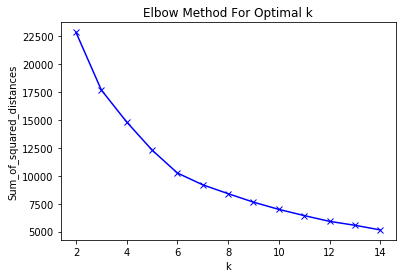

In [18]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
dummiesCluster = pd.get_dummies(km.labels_,prefix = "cluster_")

In [20]:
meanDF = pd.concat([meanDF,dummiesCluster],axis=1)

In [21]:
df = pd.read_csv('../data/test.csv')

In [22]:
df = joinMean(df)

In [23]:
df = joinPropDest(df)
df = joinPropDestTotal(df)
df = joinDiffPriceTest(df)

In [24]:
df = joinDistanceTest(df)

In [25]:
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,cluster__8,cluster__9,cluster__10,cluster__11,cluster__12,cluster__13,booking_prop_dest_mean,booking_prop_total_mean,diff_price_usd,diff_distance_orig
0,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,3180,3,4.5,...,0,0,0,0,0,0,0.077778,0.043011,0.268703,NaN
1,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,5543,3,4.5,...,0,0,0,0,0,0,0.142857,0.053279,0.258042,NaN
2,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,14142,2,3.5,...,0,0,0,0,0,0,0.000000,0.013423,-0.477593,NaN
3,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,22393,3,4.5,...,0,0,0,0,0,0,0.026316,0.013793,0.524576,NaN
4,1,2013-02-02 15:27:40,24,216,NaN,NaN,219,24194,3,4.5,...,0,0,0,0,0,0,0.010870,0.014634,-0.157752,NaN


In [26]:
df.to_csv('../data/testWithMean.csv',index=False)

In [ ]:
df = pd.read_csv('../data/train.csv')
df = joinMean(df)
df = joinPropDest(df)
df = joinPropDestTotal(df)
df = joinDistanceTrain(df)
df = joinDiffPriceTrain(df)
df.to_csv('../data/trainWithMean.csv',index=False)

Split train in train and test

In [ ]:
df = shuffle(df,random_state = 10)

In [ ]:
n = 20
numOfRowsTest = (int(len(df)*(n/100)))
X_test = df.tail(numOfRowsTest)
df.drop(df.tail(numOfRowsTest).index,inplace=True)

In [ ]:
X_test.to_csv('../data/20PercentTestWithMean.csv',index=False)
df.to_csv('../data/80PercentTrainWithMean.csv',index=False)